# CNN Interpretation - Sensitive Area Detection

Note: This notebook is desinged to run with Python3 and GPU runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_gpu.png)

####[CIS-01]
Import modules and set a random seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras import layers, models
from keras.datasets import mnist

Using TensorFlow backend.


####[CIS-02]
Define a function to detect the sensitive areas in the second filters against the input image, and generate a heatmap.

In [0]:
import cv2
from keras import preprocessing

def get_heatmap(target_image):
    target_image = target_image.reshape(1, 28*28)
    pred = np.argmax(model.predict(target_image))
    pred_output = model.output[:,pred]
    last_conv_layer = model.get_layer('conv_filter2')
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input],
                         [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_val, conv_layer_output_val = iterate([target_image])

    for i in range(last_conv_layer.output.shape[-1]):
        conv_layer_output_val[:,:,i] *= pooled_grads_val[i]

    heatmap = np.mean(conv_layer_output_val, axis=-1)
    heatmap = np.abs(heatmap)
    heatmap /= np.max(heatmap)

    heatmap2 = np.uint8(255 * cv2.resize(heatmap, (28, 28)))
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    target_image2 = np.uint8(255 * target_image.reshape(28, 28))
    target_image2 = cv2.applyColorMap(target_image2, cv2.COLORMAP_BONE)
    superimposed_img = heatmap2 + target_image2 * 0.6
    cv2.imwrite('/tmp/result.jpg', superimposed_img)

    return heatmap, preprocessing.image.load_img('/tmp/result.jpg')

####[CIS-03]
Download the MNIST dataset and store into NumPy arrays.

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

####[CIS-04]
Mount your Google Drive on `/content/gdrive`.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####[CIS-05]
Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.

In [5]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.hd5'

-rw------- 1 root root 38M Jun  8 06:44 '/content/gdrive/My Drive/MNIST_double.hd5'


####[CIS-06]
Restore the model from the exported model file.

In [6]:
model = models.load_model('/content/gdrive/My Drive/MNIST_double.hd5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter1 (Conv2D)        (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv_filter2 (Conv2D)        (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 7, 7, 64)          0         
_______________________________________

####[CIS-07]
Show heatmaps for sample images.

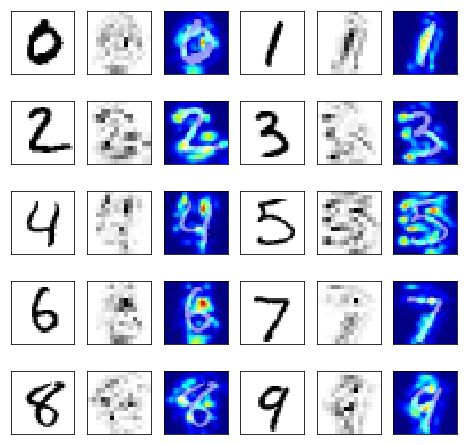

In [7]:
fig = plt.figure(figsize=(8, 8))
i = 1
for img in test_images[[3, 5, 1, 32, 4, 15, 21, 0, 84, 12]]:
    heatmap, superimposed = get_heatmap(img)

    subplot= fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot= fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot= fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)
  
    i += 3